In [ ]:

# data processing
import numpy as np
import pandas as pd
from numpy import var
import warnings

# צachine learning library
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import torch
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc

# data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# inner functions
from svm_utils import *
from data_configuration import *

In [ ]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## K-Means functions

''k_means_identify'' function train a logistic regression model on training data and evaluate its performance using accuracy, precision, recall, and f1 score metrics.
Identify mispredictions by comparing the model's predictions with actual target variables, and group them into similar clusters using k-means clustering.
Select the most important features for each cluster of mispredictions using SelectKBest method.
Remove the least important features, retrain the model, and calculate the improvement in accuracy, precision, recall, and f1 score compared to the original model.

In [ ]:
def k_means_identify(X_train, X_test, Y_train, Y_test, word):
    # Collect data on model faults and mispredictions : Logistic Regression
    # Scale the inputs to have zero mean and unit variance
    scaler = StandardScaler()
    reg_model = LogisticRegression(max_iter=1000)
    reg_model.fit(scaler.fit_transform(X_train), Y_train)

    # Predict the target variable for the testing set
    Y_pred = reg_model.predict(scaler.fit_transform(X_test))
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    print('Logistic Regression before changes: accuracy, precision, recall, f1: ', accuracy, precision, recall, f1)

    # Identify the mispredictions and their associated feature values
    data_test = X_test.copy()
    data_test[word] = Y_test
    data_test['Prediction'] = Y_pred
    mispredictions = data_test[data_test[word] != data_test['Prediction']]

    # Use the elbow method to determine the optimal number of clusters
    mispredictions_array = mispredictions.drop([word, 'Prediction'], axis=1).values
    distortions = []
    for n_clusters in range(2, 20):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
        kmeans.fit(mispredictions_array)
        distortions.append(kmeans.inertia_)

    # Select the optimal number of clusters based on the elbow method
    best_n_clusters = 0
    best_distortion = float('inf')
    for i in range(len(distortions) - 1):
        if abs(distortions[i] - distortions[i + 1]) < best_distortion:
            best_n_clusters = i + 2
            best_distortion = abs(distortions[i] - distortions[i + 1])

    # Use the optimal number of clusters determined by the elbow method
    n_clusters = best_n_clusters
    accuracy_dict = {}
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}

    # Use k-means clustering to identify groups of similar customers
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    clusters = kmeans.fit_predict(mispredictions.drop([word, 'Prediction'], axis=1))

    # Use SelectKBest to identify the important features
    for i in range(n_clusters):
        cluster_data = mispredictions[clusters == i].drop([word, 'Prediction'], axis=1)
        X = cluster_data.values
        Y = data_test[data_test[word] != data_test['Prediction']][word][clusters == i]

        # Remove constant features
        constant_features = [j for j, column in enumerate(X.T) if var(column) == 0]
        X = np.delete(X, constant_features, axis=1)
        cluster_data = cluster_data.drop(cluster_data.columns[constant_features], axis=1)
        if X.shape[1] == 0:
            print("All features are constant in this cluster")
        else:
            selector = SelectKBest(f_classif, k=1)
            selector = selector.fit(X, Y)
            mask = selector.get_support()
            important_features = cluster_data.columns[mask]

            # Make changes to the predictive model by removing the least important features
            X_train_new = X_train.drop(important_features, axis=1)
            X_test_new = X_test.drop(important_features, axis=1)
            model_new = LogisticRegression(max_iter=1000)
            model_new.fit(scaler.fit_transform(X_train_new), Y_train)
            Y_pred_new = model_new.predict(scaler.fit_transform(X_test_new))
            accuracy_new = accuracy_score(Y_test, Y_pred_new)
            accuracy_dict.update({i: accuracy_new})
            precision_new = precision_score(Y_test, Y_pred_new)
            precision_dict.update({i: precision_new})
            recall_new = recall_score(Y_test, Y_pred_new)
            recall_dict.update({i: recall_new})
            f1_new = f1_score(Y_test, Y_pred_new)
            f1_dict.update({i: f1_new})
    max_accuracy = max(accuracy_dict.values())
    print('The max accuracy we could get is', max_accuracy)
    max_precision = max(precision_dict.values())
    print('The max precision we could get is', max_precision)
    max_recall = max(recall_dict.values())
    print('The max recall we could get is', max_recall)
    max_f = max(f1_dict.values())
    print('The max f1 we could get is', max_f)
    print('We gain a better accuracy of the model of', (max_accuracy - accuracy) * 100, '%')
    print('We gain a better precision of the model of', (max_precision - precision) * 100, '%')
    print('We gain a better recall of the model of', (max_recall - recall) * 100, '%')
    print('We gain a better f1 score of the model of', (max_f - f1) * 100, '%')

"py_optimize_neural" function creates a neural network model for binary classification by first scaling the input data, creating a feedforward neural network with two fully connected linear layers, ReLU activation functions, and a sigmoid output activation. The model is trained for 100 epochs using the binary cross entropy loss and Adam optimizer. After training, the model is evaluated on the test data using accuracy, precision, recall, F1 score, confusion matrix and ROC curve. The results are printed and visualized using a bar plot and ROC curve.

In [ ]:
def py_optimize_neural(X_tr, X_te, Y_tr, Y_te):
    # Use PyTorch to optimize the model parameters and improve the accuracy of the predictions
    num_epochs = 100
    learning_rate = 0.01
    input_size = X_tr.shape[1]
    hidden_size = 10
    output_size = 1

    # Scale the inputs to have zero mean and unit variance
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.fit_transform(X_te)

    # Convert the data to PyTorch tensors
    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    Y_tr = torch.tensor(Y_tr.values, dtype=torch.float32)
    X_te = torch.tensor(X_te, dtype=torch.float32)
    Y_te = torch.tensor(Y_te.values, dtype=torch.float32)
    model = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, output_size),
        torch.nn.Sigmoid()
    )
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_tr)
        Y_tr = Y_tr.view(-1, 1)
        loss = criterion(outputs, Y_tr)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Use the trained model to make predictions on the test set
    test_outputs = model(X_te)
    Y_te = Y_te.view(-1, 1)

    # Evaluate the performance of the model using accuracy and other metrics
    test_predictions = (test_outputs.detach().numpy() > 0.5).astype(int)
    test_actuals = Y_te.detach().numpy().astype(int)
    accuracy = accuracy_score(test_actuals, test_predictions)
    precision = precision_score(test_actuals, test_predictions, zero_division=1)
    recall = recall_score(test_actuals, test_predictions)
    f1 = f1_score(test_actuals, test_predictions)
    print(
        'Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 score: {:.3f}'.format(accuracy, precision, recall, f1))

    # Create a bar plot of the evaluation metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 score']
    values = [accuracy, precision, recall, f1]
    plt.bar(metrics, values)
    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Value')
    plt.show()

    # Calculate the confusion matrix
    cm = confusion_matrix(test_actuals, test_predictions)

    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.yticks([0, 1], ['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(test_actuals, test_outputs.detach().numpy())
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

This function compares the performance of three different machine learning models (logistic regression, random forest, and support vector machine) using PyTorch and the sklearn library. The models are defined using the Pipeline class from sklearn and their hyperparameters are stored in a dictionary. A 5-fold cross-validation is performed on each model using the GridSearchCV class from sklearn to find the best hyperparameters based on accuracy. The best score and best hyperparameters for each model are stored in a dictionary and printed. A bar plot is also created to visualize the accuracy of the different models.

In [ ]:
def py_different_model(X_train, Y_train):
    # Define the pipelines for the different models to be compared
    pipelines = {
        'lr': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))]),
        'rf': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier())]),
        'svc': Pipeline([('scaler', StandardScaler()), ('clf', SVC())])
    }

    # Define the hyperparameters for the different models
    hyperparameters = {
        'lr': {'clf__C': [0.1, 1.0, 10.0]},
        'rf': {'clf__n_estimators': [10, 100, 1000]},
        'svc': {'clf__C': [0.1, 1.0, 10.0], 'clf__kernel': ['linear', 'rbf']}
    }

    # Use PyTorch to compare the performance of the different models using cross-validation
    num_folds = 5
    results = {}
    """for model_name, pipeline in pipelines.items():
        clf = GridSearchCV(pipeline, hyperparameters[model_name], cv=num_folds, scoring='accuracy')
        clf.fit(X_train, Y_train)
        results[model_name] = clf.best_score_

    # Select the best model based on the cross-validation results
    best_model = max(results, key=results.get)
    print('Best model:', best_model)"""
    for model_name, pipeline in pipelines.items():
        clf = GridSearchCV(pipeline, hyperparameters[model_name], cv=num_folds, scoring='accuracy', n_jobs=-1)
        clf.fit(X_train, Y_train)
        results[model_name] = {
            'best_score': clf.best_score_,
            'best_params': clf.best_params_,
            'cv_results': clf.cv_results_
        }

    # Print the results for each model
    for model_name, result in results.items():
        print('Model:', model_name)
        print('Best score:', result['best_score'])
        print('Best params:', result['best_params'])
        print()

    # Visualize the accuracy of the different models
    model_names = list(results.keys())
    model_scores = [result['best_score'] for result in results.values()]
    plt.bar(model_names, model_scores)
    plt.title('Accuracy of Different Models')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.show()

This function is used to visualize the results of the logistic regression model to better understand the model faults and mispredictions. The first step involves standardizing the features of the training and testing sets with the StandardScaler class to have zero mean and unit variance. The logistic regression model is then fit to the standardized training set.
Next, the target variables of the testing set are predicted using the predict method and converted to PyTorch tensors. These tensors are used to create two different plots to visualize the distribution of the predictions and actual outcomes. The first plot is a histogram showing the frequency of target variables for both predictions and actual outcomes, and the second plot is a kernel density estimate showing the probability density of target variables for both predictions and actual outcomes.

In [ ]:
def kmeans_results_visualization(X_train, X_test, Y_train, Y_test):
    # Logistic Regression
    # Scale the inputs to have zero mean and unit variance
    scaler = StandardScaler()
    reg_model = LogisticRegression(max_iter=1000)
    reg_model.fit(scaler.fit_transform(X_train), Y_train)

    # Predict the target variable for the testing set
    Y_pred = reg_model.predict(scaler.fit_transform(X_test))
    # Convert the predictions and actual outcomes to PyTorch tensors
    Y_pred_torch = torch.tensor(Y_pred, dtype=torch.float32)
    Y_test_torch = torch.tensor(Y_test.values, dtype=torch.float32)

    # Plot the distribution of model predictions and actual outcomes, histogram plot
    plt.hist(Y_pred_torch.detach().numpy(), bins=20, alpha=0.5, label='Predictions')
    plt.hist(Y_test_torch, bins=20, alpha=0.5, label='Actual Outcomes')
    plt.legend(loc='upper right')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

    # Plot the distribution of predictions and actual outcomes, kernel density estimate plot
    sns.kdeplot(Y_pred_torch.numpy(), label='Predictions')
    sns.kdeplot(Y_test_torch.numpy(), label='Actual Outcomes')
    plt.title('Distribution of Predictions and Actual Outcomes')
    plt.xlabel('Outcome')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## SVM functions

In [ ]:
def svm_training(X_train, X_test, Y_train, Y_test, dataset, label):
    # Standardize features. Require for Machine learning
    sc = StandardScaler()
    # Fit to data, then transform it
    X_train = sc.fit_transform(X_train)

    # Perform standardization by centering and scaling
    X_test = sc.transform(X_test)

    # Init an H2O cluster
    h2o.init()

    # Convert training data to H2OFrame
    # the train result will be used to train a machine learning model
    train = h2o.H2OFrame(np.concatenate((X_train, Y_train.values.reshape(-1, 1)), axis=1))
    train.columns = list(dataset.columns)

    # Specify target variable and predictor variables
    x = train.drop(label, axis=1).columns
    y = label
    
    # Run H2O AutoML to automatically select, train and optimize SVM model
    aml = H2OAutoML(max_models=10, sort_metric='mse', max_runtime_secs=5 * 60, seed=666)
    aml.train(x=x, y=y, training_frame=train)
    
    # View the leaderboard of trained models
    lb = aml.leaderboard
    print(lb.head())

    # Use the best model to predict on test data
    model = aml.leader
    X_h2o = h2o.H2OFrame(X_test)
    X_h2o.columns = [col_name for col_name in dataset.columns if col_name != label]
    y_pred = model.predict(X_h2o).as_data_frame().values.flatten()

    # Train a PySVM SVM model
    model = LinearSVC(random_state=0, tol=1e-5, max_iter=10000, dual=False)
    Y_pred = model.fit(X_train, Y_train)

    # Test the model on the test data
    y_pred = model.predict(X_test)
    misclassified = np.where(Y_test != y_pred)[0]
    print("Indices of potentially misclassified instances: ", misclassified)

    # Confusion matrix - summarizing the performance of a classification algorithm.
    cm = confusion_matrix(Y_test, y_pred)
    plt.figure()
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks([0, 1], ["Negative", "Positive"])
    plt.yticks([0, 1], ["Negative", "Positive"])
    plt.tight_layout()
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()

### Company Bankrupt Dataset

1. Data Pre-Processing

In [116]:
# Load the company bankrupt dataset into dataframe.
bankrupt_df = pd.read_csv('../data/raw/company_bankruptcy.csv')
bankrupt_df.head(5)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [117]:
# Find out how many Nan values are in the dataset now
bankrupt_df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [118]:
# There are no missing values in any of the columns. Dataset seems to be clean
# display general statistics of dataset
bankrupt_df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [119]:
X_bankrupt = bankrupt_df.drop(["Bankrupt?"], axis=1)
Y_bankrupt = bankrupt_df["Bankrupt?"]

over_sample = SMOTE()
X_ros_bankrupt, Y_ros_bankrupt = over_sample.fit_resample(X_bankrupt, Y_bankrupt)

# we split the data into training and testing sets
X_train_bankrupt, X_test_bankrupt, Y_train_bankrupt, Y_test_bankrupt = train_test_split(X_ros_bankrupt, Y_ros_bankrupt, test_size=0.2, random_state=42)

Present the relationship between all pairs of columns in a dataset

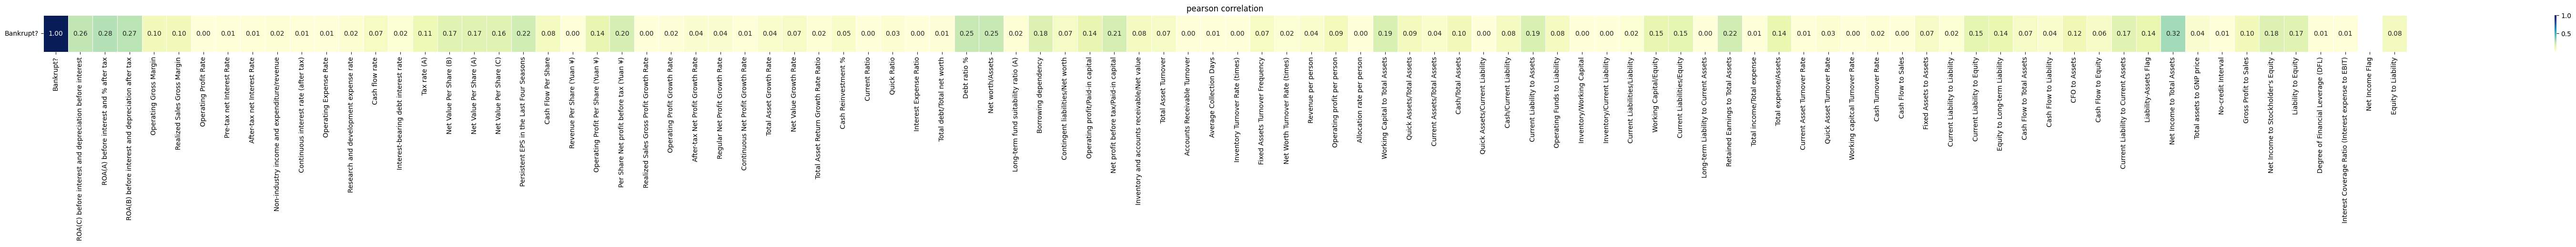

In [124]:
corr = corr_matrix(bankrupt_df, method="pearson", negative=False, lst_filters=["Bankrupt?"], figsize=(80,1))

<Axes: >

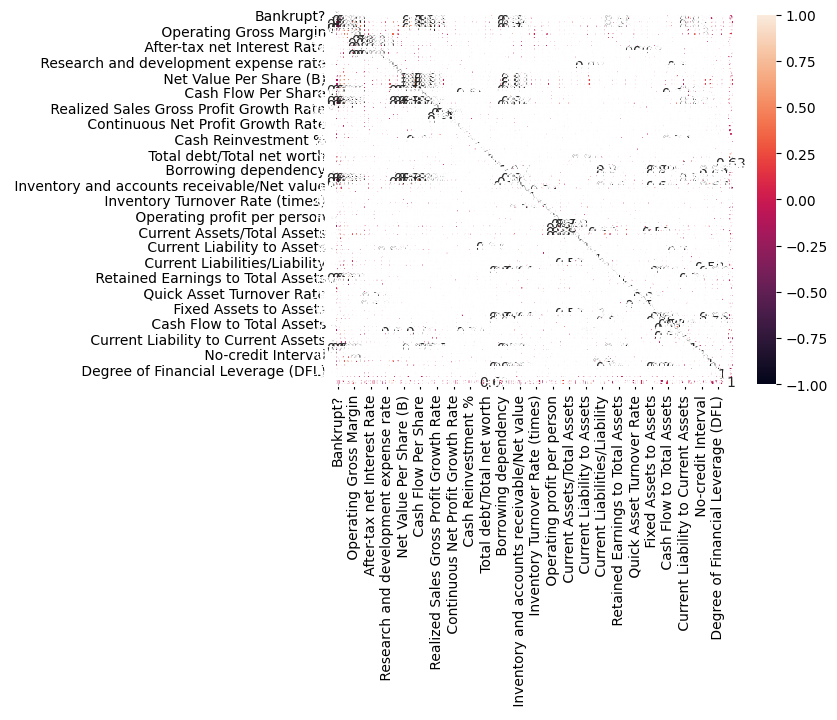

In [125]:
sns.heatmap(bankrupt_df.corr(), annot=True)

In [ ]:
k_means_identify(X_train_bankrupt, X_test_bankrupt, Y_train_bankrupt, Y_test_bankrupt, "Bankrupt?")

In [ ]:
py_optimize_neural(X_train_bankrupt, X_test_bankrupt, Y_train_bankrupt, Y_test_bankrupt)

In [ ]:
py_different_model(X_train_bankrupt, Y_train_bankrupt)

In [ ]:
kmeans_results_visualization(X_train_bankrupt, X_test_bankrupt, Y_train_bankrupt, Y_test_bankrupt)

3. SVM training

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,52 mins 30 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_Administrator_saw39q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.457 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
19:24:25.155: AutoML: XGBoost is not available; skipping it.
19:24:25.246: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]

██
19:24:33.556: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]

█████████████████████████████████████
19:27:34.742: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]

███████████████████████| (done) 100%
model_id                                mse           rmse          mae    rmsle    mean_residual_deviance
GBM_1_AutoML_3_20230302_192425  0.0087904        0.0937571    0.0472111      nan               0.0087904
GLM_1_AutoML_3_20230302_192425  1.28551e+09  35854          349.166          nan               1.28551e+09
[2 rows x 6 columns]

Parse progress: |██████████████████████████████████

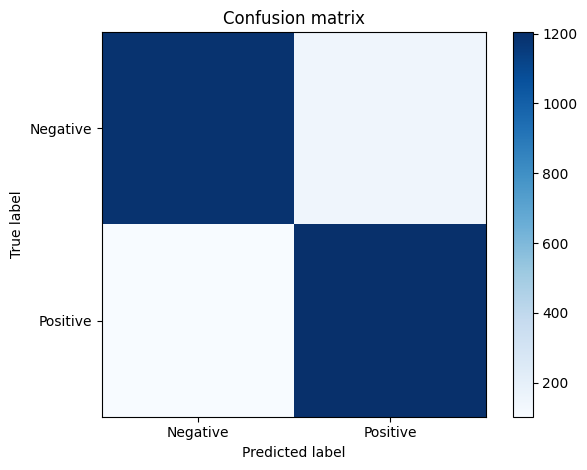

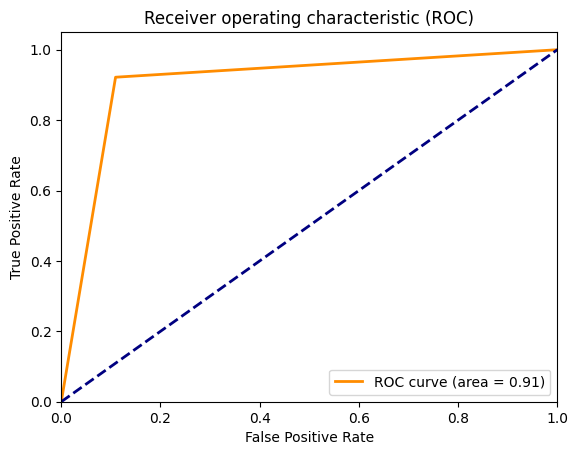

In [121]:
svm_training(X_train_bankrupt, X_test_bankrupt, Y_train_bankrupt, Y_test_bankrupt, bankrupt_df, "Bankrupt?")

### Customer Churn Dataset

1. Data Pre-Processing

In [122]:
# Load the customer churn dataset into dataframe.
churn_df = pd.read_csv('../data/raw/customer_churn.csv')
churn_df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Total Charges column was categorical but must be a numerical value.
# hence we convert it to categorical and fill with NAN values if there are errors.
churn_df["TotalCharges"] = pd.to_numeric(churn_df["TotalCharges"], errors='coerce')

In [ ]:
# Find out how many Nan values are in the dataset now
churn_df.isnull().sum()

In [ ]:
# drop NaN values since they are small
churn_df.dropna(subset=["TotalCharges"], inplace=True)
churn_df.isnull().sum()

In [ ]:
# Also we don't need the customer ID columm
churn_df.drop("customerID", axis=1, inplace=True)

In [ ]:
# As expected there are no missing values in any of the columns. Dataset seems to be clean
# display general statistics of dataset
churn_df.describe()

In [ ]:
# maping of male to 1 and female to zero.
churn_df['gender'] = churn_df['gender'].map({'Male': 1, 'Female': 0})
# maping of yes to 1 and No to 0 for the following column
churn_df['Partner'] = churn_df['Partner'].map({'Yes': 1, 'No': 0})
churn_df['Dependents'] = churn_df['Dependents'].map({'Yes': 1, 'No': 0})
churn_df['PhoneService'] = churn_df['PhoneService'].map({'Yes': 1, 'No': 0})
churn_df['PaperlessBilling'] = churn_df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
churn_df['Churn'] = churn_df['Churn'].map({'Yes': 1, 'No': 0})
churn_df.head(5)

In [ ]:
# get dummy for categorical columns now
churn_df = pd.get_dummies(churn_df)
churn_df.head(5)

In [ ]:
# Extract the features and labels
X_churn = churn_df.drop(['Churn'], axis=1)
Y_churn = churn_df['Churn']

over_sample = SMOTE()
X_ros_churn, Y_ros_churn = over_sample.fit_resample(X_churn, Y_churn)

# we split the data into training and testing sets
X_train_churn, X_test_churn, Y_train_churn, Y_test_churn = train_test_split(X_ros_churn, Y_ros_churn, test_size=0.2, random_state=42)

Present the relationship between all pairs of columns in a dataset

--- WARNING: Factorizing 7043 labels of customerID ---
--- WARNING: Factorizing 2 labels of gender ---
--- WARNING: Factorizing 2 labels of Partner ---
--- WARNING: Factorizing 2 labels of Dependents ---
--- WARNING: Factorizing 2 labels of PhoneService ---
--- WARNING: Factorizing 3 labels of MultipleLines ---
--- WARNING: Factorizing 3 labels of InternetService ---
--- WARNING: Factorizing 3 labels of OnlineSecurity ---
--- WARNING: Factorizing 3 labels of OnlineBackup ---
--- WARNING: Factorizing 3 labels of DeviceProtection ---
--- WARNING: Factorizing 3 labels of TechSupport ---
--- WARNING: Factorizing 3 labels of StreamingTV ---
--- WARNING: Factorizing 3 labels of StreamingMovies ---
--- WARNING: Factorizing 3 labels of Contract ---
--- WARNING: Factorizing 2 labels of PaperlessBilling ---
--- WARNING: Factorizing 4 labels of PaymentMethod ---
--- WARNING: Factorizing 6531 labels of TotalCharges ---
--- WARNING: Factorizing 2 labels of Churn ---


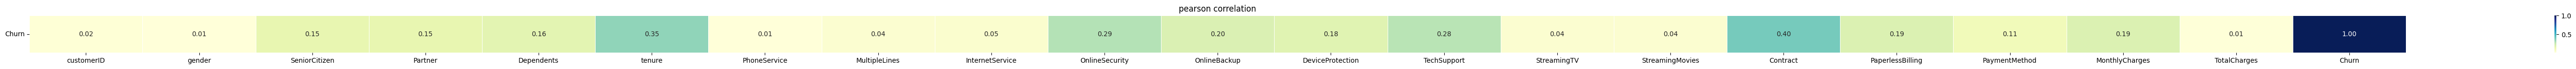

In [126]:
corr = corr_matrix(churn_df, method="pearson", negative=False, lst_filters=[ProcessConfig.churn_label], figsize=(80,1))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20616\4245345338.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(churn_df.corr(), annot=True)


<Axes: >

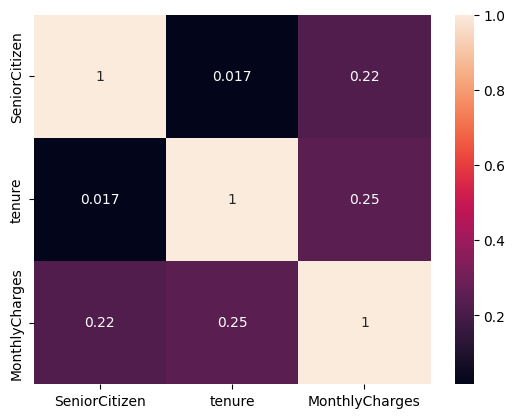

In [127]:
sns.heatmap(churn_df.corr(), annot=True)

In [ ]:
k_means_identify(X_train_churn, X_test_churn, Y_train_churn, Y_test_churn, 'Churn')

In [ ]:
py_optimize_neural(X_train_churn, X_test_churn, Y_train_churn, Y_test_churn)

In [ ]:
py_different_model(X_train_churn, Y_train_churn)

In [ ]:
kmeans_results_visualization(X_train_churn, X_test_churn, Y_train_churn, Y_test_churn)

3. SVM training

In [ ]:
svm_training(X_train_churn, X_test_churn, Y_train_churn, Y_test_churn, churn_df, ProcessConfig.churn_label)

### Diabetes Dataset

1. Data Pre-Processing

In [ ]:
# Load the diabetes dataset into dataframe.
diabetes_df = pd.read_csv('../data/raw/health_diabetes.csv')
diabetes_df.head(5)

In [ ]:
# Find out how many Nan values are in the dataset now
diabetes_df.isnull().sum()

In [ ]:
# 2. All the features are required for the ml process

# 3. Convert to numeric Outcome feature
# 0 - no diabetes. 1 - no diabetes.
diabetes_df["Outcome"] = pd.to_numeric(diabetes_df["Outcome"],
                                                              errors='coerce')

In [ ]:
diabetes_df = pd.get_dummies(diabetes_df)
diabetes_df.head(5)

In [ ]:
# After cleaning and processing the database, display general statistics of dataset
diabetes_df.describe()

Present the relationship between all pairs of columns in a dataset

In [ ]:
corr = corr_matrix(diabetes_df, method="pearson", negative=False, lst_filters=[ProcessConfig.diabetes_label], figsize=(80,1))

In [ ]:
sns.heatmap(diabetes_df.corr(), annot=True)

In [ ]:
# Extract the features and labels
X_diabetes = diabetes_df.drop(["Outcome"], axis=1)
Y_diabetes = diabetes_df["Outcome"]

over_sample = SMOTE()
X_ros_diabetes, Y_ros_diabetes = over_sample.fit_resample(X_diabetes, Y_diabetes)

# we split the data into training and testing sets
X_train_diabetes, X_test_diabetes, Y_train_diabetes, Y_test_diabetes = train_test_split(X_ros_diabetes, Y_ros_diabetes, test_size=0.2, random_state=42)

2. K-means training

In [ ]:
k_means_identify(X_train_diabetes, X_test_diabetes, Y_train_diabetes, Y_test_diabetes, 'Outcome')

In [ ]:
py_optimize_neural(X_train_diabetes, X_test_diabetes, Y_train_diabetes, Y_test_diabetes) 

In [ ]:
py_different_model(X_train_diabetes, X_test_diabetes)

In [ ]:
kmeans_results_visualization(X_train_diabetes, X_test_diabetes, Y_train_diabetes, Y_test_diabetes)

3. SVM training

In [ ]:
svm_training(X_train_diabetes, X_test_diabetes, Y_train_diabetes, Y_test_diabetes, diabetes_df, ProcessConfig.diabetes_label)

### Credit Card DataSet

1. Data Pre-Processing

In [ ]:
# Load the credit card dataset into dataframe.
creditcard_df = pd.read_csv('../data/raw/creditcard.csv')
creditcard_df.head(5)

In [ ]:
# Find out how many Nan values are in the dataset now
creditcard_df.isnull().sum()

In [ ]:
# 2. All the features are required for the ml process

# 3. Convert to numeric Class feature
# 0 - non-fraudulent. 1 - fraudulent.
creditcard_df["Class"] = pd.to_numeric(creditcard_df["Class"], errors='coerce')
creditcard_df.head(5)

In [ ]:
creditcard_df = pd.get_dummies(creditcard_df)
# After cleaning and processing the database, display general statistics of dataset
creditcard_df.describe()

Present the relationship between all pairs of columns in a dataset

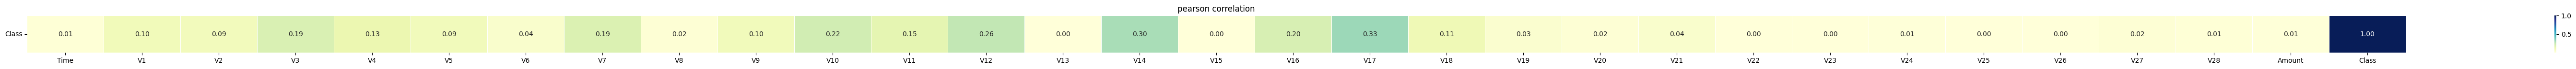

In [128]:
corr = corr_matrix(creditcard_df, method="pearson", negative=False, lst_filters=[ProcessConfig.creditcard_label], figsize=(80,1))

<Axes: >

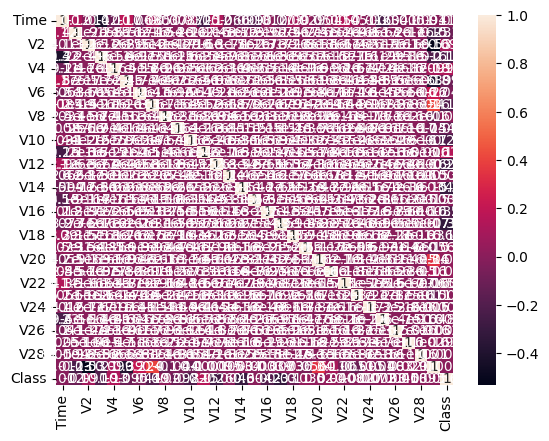

In [129]:
sns.heatmap(creditcard_df.corr(), annot=True)

In [ ]:
X_creditcard = creditcard_df.drop(["Class"], axis=1)
Y_creditcard = creditcard_df["Class"]

over_sample = SMOTE()
X_ros_creditcard, Y_ros_creditcard = over_sample.fit_resample(X_creditcard, Y_creditcard)

# we split the data into training and testing sets
X_train_creditcard, X_test_creditcard, Y_train_creditcard, Y_test_creditcard = train_test_split(X_ros_creditcard, Y_ros_creditcard, test_size=0.2, random_state=42)

2. K-means training

In [ ]:
k_means_identify(X_train_creditcard, X_test_creditcard, Y_train_creditcard, Y_test_creditcard, "Class")

In [ ]:
py_optimize_neural(X_train_creditcard, X_test_creditcard, Y_train_creditcard, Y_test_creditcard)

In [ ]:
py_different_model(X_train_creditcard, X_test_creditcard)  

In [ ]:
kmeans_results_visualization(X_train_creditcard, X_test_creditcard, Y_train_creditcard, Y_test_creditcard)

3. SVM training

In [ ]:
svm_training(X_train_creditcard, X_test_creditcard, Y_train_creditcard, Y_test_creditcard, creditcard_df, ProcessConfig.creditcard_label)